In [1]:
import os 
import json
import pickle
import datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import Normalizer

import pandas as pd
from pprint import pprint
from bisect import bisect_left as find_prev
import matplotlib.pyplot as plt

import xml.etree.ElementTree as xml

strptime = datetime.datetime.strptime
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
episodes_numbers = list(map(str, range(60, 70+1))) + list(map(str, range(79, 89+1)))
videos_data      = xml.parse('eastenders.collection.xml').getroot().findall("./VideoFile")

episodes_filenames = {v.find('id').text : v.find('filename').text
                      for v in videos_data
                      if v.find('id').text in episodes_numbers}
episodes_filenames

{'60': '5245830105934359183.mp4',
 '61': '5248439298566680341.mp4',
 '62': '5251033029316736209.mp4',
 '63': '5253646087419594905.mp4',
 '64': '5256228221757951173.mp4',
 '65': '5258818087037440299.mp4',
 '66': '5264050645694159353.mp4',
 '67': '5266645664934403562.mp4',
 '68': '5269245838135402929.mp4',
 '69': '5271844722846213628.mp4',
 '70': '5274434588125702436.mp4',
 '79': '5300410550331962313.mp4',
 '80': '5300433743159556513.mp4',
 '81': '5303026185415228226.mp4',
 '82': '5305617339184877785.mp4',
 '83': '5308226531817199474.mp4',
 '84': '5310822839547632763.mp4',
 '85': '5313398531435045858.mp4',
 '86': '5316007724067368375.mp4',
 '87': '5318609185758554501.mp4',
 '88': '5321170704253895214.mp4',
 '89': '5323778608396028180.mp4'}

In [3]:
shots_starts = {}
shots_ends = {}
shots_ids = {}

for line in open('eastenders.masterShotReferenceTable.txt', 'r'):
    line = line.strip()
    if not line: continue
    episode_number = line.split()[0].strip()
    if episode_number in episodes_numbers:
        file = episodes_filenames[episode_number]
        if file not in shots_starts: 
            shots_starts[file] = []
            shots_ends[file] = []
            shots_ids[file] = []
        _, shot_id, start, end = line.split()
        
        shot_number = int(shot_id.split('_')[1])
        if (int(episode_number) < 71 and shot_number > 2040) or (int(episode_number) > 78 and shot_number > 2036):
            continue
        ref = datetime.datetime(1900, 1, 1)
        start = (strptime(start[1:12], '%H:%M:%S:%f') - ref).total_seconds()
        end   = (strptime(end[1:12], '%H:%M:%S:%f') - ref).total_seconds()

        shots_starts[file].append(start)
        shots_ends[file].append(end)
        shots_ids[file].append(int(shot_id.split('_')[1]))

In [4]:
shots_ids.keys()

dict_keys(['5245830105934359183.mp4', '5248439298566680341.mp4', '5251033029316736209.mp4', '5253646087419594905.mp4', '5256228221757951173.mp4', '5258818087037440299.mp4', '5264050645694159353.mp4', '5266645664934403562.mp4', '5269245838135402929.mp4', '5271844722846213628.mp4', '5274434588125702436.mp4', '5300410550331962313.mp4', '5300433743159556513.mp4', '5303026185415228226.mp4', '5305617339184877785.mp4', '5308226531817199474.mp4', '5310822839547632763.mp4', '5313398531435045858.mp4', '5316007724067368375.mp4', '5318609185758554501.mp4', '5321170704253895214.mp4', '5323778608396028180.mp4'])

In [5]:
shots_starts['5245830105934359183.mp4'][:3], shots_ends['5245830105934359183.mp4'][:3], shots_ids['5245830105934359183.mp4'][:3]

([0.0, 20.22, 23.21], [20.21, 23.2, 25.14], [1, 2, 3])

In [6]:
shots_ids['5245830105934359183.mp4'][-10:]

[2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040]

In [109]:
j = json.load(open('../facerec/1.all_people/5256228221757951173.json', 'r'))

In [110]:
j.keys()

dict_keys(['locator', 'media', 'status', 'project', 'tracks', 'feat_clusters'])

In [111]:
j['locator']

'/data/eastenders/5256228221757951173.mp4'

In [5]:
j['tracks']

NameError: name 'j' is not defined

In [11]:
len(j)

6

In [6]:
data = []
for filename in os.listdir('../facerec/2.only_main/'):
    j = json.load(open('../facerec/2.only_main/'+filename, 'r'))
    for rec in j:
        for track in j['tracks']:
            d = {}
            d['file'] = str(filename.replace('json', 'mp4'))
            d['confidence'] = float(track['confidence'])
            d['start_second'] = float(track['start_npt'])
            d['end_second'] = float(track['end_npt'])
            d['start_frame'] = int(track['start_frame'])
            d['end_frame'] = int(track['end_frame'])
            d['character'] = str(track['name'])
            data.append(d)

In [7]:
df = pd.DataFrame(data)
df.head()

,file,confidence,start_second,end_second,start_frame,end_frame,character
0,5321170704253895214.mp4,0.487189,76.0,78.0,1900,1950,Peggy Mitchell
1,5321170704253895214.mp4,0.589437,165.0,166.0,4125,4150,Peggy Mitchell
2,5321170704253895214.mp4,0.524413,169.0,171.0,4225,4275,Peggy Mitchell
3,5321170704253895214.mp4,0.431605,317.0,320.0,7925,8000,Peggy Mitchell
4,5321170704253895214.mp4,0.587939,583.0,585.0,14575,14625,Peggy Mitchell


In [8]:
df[df.file == '5256228221757951173.mp4'].character.unique()

array(['Peggy Mitchell', 'Tanya Branning', 'Jack Branning',
       'Archie Mitchell', 'Max Branning'], dtype=object)

In [9]:
df['file'] = df['file'].astype(str)
df['character'] = df['character'].astype(str)
df['start_frame'] = df['start_frame'].astype(int)
df['end_frame'] = df['end_frame'].astype(int)
df['start_second'] = df['start_second'].astype(float)
df['end_second'] = df['end_second'].astype(float)
df['confidence'] = df['confidence'].astype(float)

In [10]:
df

,file,confidence,start_second,end_second,start_frame,end_frame,character
0,5321170704253895214.mp4,0.487189,76.0,78.0,1900,1950,Peggy Mitchell
1,5321170704253895214.mp4,0.589437,165.0,166.0,4125,4150,Peggy Mitchell
2,5321170704253895214.mp4,0.524413,169.0,171.0,4225,4275,Peggy Mitchell
3,5321170704253895214.mp4,0.431605,317.0,320.0,7925,8000,Peggy Mitchell
4,5321170704253895214.mp4,0.587939,583.0,585.0,14575,14625,Peggy Mitchell
...,...,...,...,...,...,...,...
39829,5274434588125702436.mp4,0.448474,6047.0,6049.0,151175,151225,Max Branning
39830,5274434588125702436.mp4,0.604398,6228.0,6232.0,155700,155800,Max Branning
39831,5274434588125702436.mp4,0.506472,6274.0,6275.0,156850,156875,Max Branning
39832,5274434588125702436.mp4,0.594016,6297.0,6299.0,157425,157475,Max Branning


In [27]:
df.dtypes

file             object
confidence      float64
start_second    float64
end_second      float64
start_frame       int64
end_frame         int64
character        object
dtype: object

In [28]:
df.describe()

,confidence,start_second,end_second,start_frame,end_frame
count,34278.000000,34278.000000,34278.000000,34278.000000,34278.000000
mean,0.635647,3233.109750,3235.427096,80827.743742,80885.677402
std,0.147484,1963.389679,1963.435593,49084.741977,49085.889826
min,0.400023,25.000000,26.000000,625.000000,650.000000
25%,0.511238,1485.000000,1488.000000,37125.000000,37200.000000
50%,0.619259,3153.000000,3156.000000,78825.000000,78900.000000
75%,0.747455,4747.000000,4749.000000,118675.000000,118725.000000
max,0.995121,8586.000000,8587.000000,214650.000000,214675.000000


In [12]:
#df.name.unique()

In [13]:
df_cut = df[df.confidence > 0.4]

In [44]:
df_cut.describe()

,confidence,start_second,end_second,start_frame,end_frame
count,34278.000000,34278.000000,34278.000000,34278.000000,34278.000000
mean,0.635647,3233.109750,3235.427096,80827.743742,80885.677402
std,0.147484,1963.389679,1963.435593,49084.741977,49085.889826
min,0.400023,25.000000,26.000000,625.000000,650.000000
25%,0.511238,1485.000000,1488.000000,37125.000000,37200.000000
50%,0.619259,3153.000000,3156.000000,78825.000000,78900.000000
75%,0.747455,4747.000000,4749.000000,118675.000000,118725.000000
max,0.995121,8586.000000,8587.000000,214650.000000,214675.000000


In [14]:
df_cut.character.unique()

array(['Peggy Mitchell', 'Tanya Branning', 'Jack Branning',
       'Archie Mitchell', 'Max Branning'], dtype=object)

In [ ]:
#episodes with few apperances
#'5256228221757951173.mp4

In [ ]:
df_cut.5256228221757951173.mp4

In [48]:
episodes_filenames

{'60': '5245830105934359183.mp4',
 '61': '5248439298566680341.mp4',
 '62': '5251033029316736209.mp4',
 '63': '5253646087419594905.mp4',
 '64': '5256228221757951173.mp4',
 '65': '5258818087037440299.mp4',
 '66': '5264050645694159353.mp4',
 '67': '5266645664934403562.mp4',
 '68': '5269245838135402929.mp4',
 '69': '5271844722846213628.mp4',
 '70': '5274434588125702436.mp4',
 '79': '5300410550331962313.mp4',
 '80': '5300433743159556513.mp4',
 '81': '5303026185415228226.mp4',
 '82': '5305617339184877785.mp4',
 '83': '5308226531817199474.mp4',
 '84': '5310822839547632763.mp4',
 '85': '5313398531435045858.mp4',
 '86': '5316007724067368375.mp4',
 '87': '5318609185758554501.mp4',
 '88': '5321170704253895214.mp4',
 '89': '5323778608396028180.mp4'}

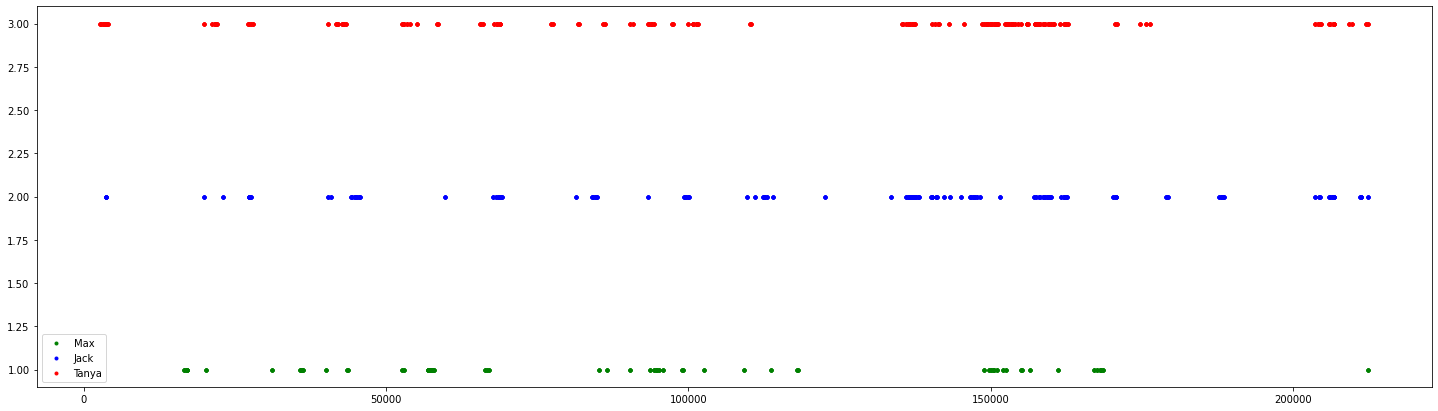

In [29]:
appearances = {'Max Branning':[], 'Jack Branning':[], 'Tanya Branning':[]}
for i, e in df_cut[df_cut.file == '5264050645694159353.mp4'].iterrows():
    if e['character'] in appearances:
        appearances[e['character']].append(e['start_frame'])

fig, ax = plt.subplots(figsize=(25,7))

ax.scatter(appearances['Max Branning'], [1]*len(appearances['Max Branning']), marker='.',
        color='green',  label='Max')
ax.scatter(appearances['Jack Branning'], [2]*len(appearances['Jack Branning']),marker='.',
        color='blue',  label='Jack')
ax.scatter(appearances['Tanya Branning'], [3]*len(appearances['Tanya Branning']), marker='.',
        color='red', label='Tanya')

ax.legend()
plt.show()

In [16]:
cut = 0.5
keep = 2
add = 2

In [17]:
df_cut = df[df.confidence > cut]

In [18]:
df_cut

,file,confidence,start_second,end_second,start_frame,end_frame,character
1,5321170704253895214.mp4,0.589437,165.0,166.0,4125,4150,Peggy Mitchell
2,5321170704253895214.mp4,0.524413,169.0,171.0,4225,4275,Peggy Mitchell
4,5321170704253895214.mp4,0.587939,583.0,585.0,14575,14625,Peggy Mitchell
5,5321170704253895214.mp4,0.578407,615.0,616.0,15375,15400,Peggy Mitchell
7,5321170704253895214.mp4,0.754803,849.0,850.0,21225,21250,Peggy Mitchell
...,...,...,...,...,...,...,...
39819,5274434588125702436.mp4,0.530766,5318.0,5323.0,132950,133075,Max Branning
39820,5274434588125702436.mp4,0.577022,5327.0,5329.0,133175,133225,Max Branning
39830,5274434588125702436.mp4,0.604398,6228.0,6232.0,155700,155800,Max Branning
39831,5274434588125702436.mp4,0.506472,6274.0,6275.0,156850,156875,Max Branning


In [19]:
recs = {f:set() for f in df.file.unique()}
kept = {}
for i, e in df_cut.iterrows():
    file = e['file']
    k = find_prev(shots_starts[file], e['start_second'])
    recs[file].add(k-1)
    recs[file].add(k)
    recs[file].add(k+1)
    
    if (file, k, e['character']) not in kept:
        kept[(file, k, e['character'])] = []
    kept[(file, k, e['character'])].append(e['confidence'])
    
    if add == 2: 
        recs[file].add(k-2)
        recs[file].add(k+2)
        
    # if len(recs[file]) < 4:
    #    print(file, e['second'], k, recs[file])

In [88]:
# kept[('5313398531435045858.mp4', 245, 'Tanya Branning')]

In [2]:
data_kept = []
for k in kept:
    file, shot_id, character = k
    data_kept.append((file, shot_id, character, sum(kept[k])/len(kept[k])))

NameError: name 'kept' is not defined

In [76]:
df_kept = pd.DataFrame(data_kept, columns=['file', 'shot_id', 'character', 'avg_confidence'])
df_kept['file']=df_kept['file'].str.replace('.mp4','')


/home/semantic/.conda/envs/areboudpy37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Unnamed: 0,file,shot_id,character,avg_confidence,unique_id
0,0,5321170704253895214.mp4,47,Peggy Mitchell,0.556925,47_5321170704253895214.mp4
1,1,5321170704253895214.mp4,188,Peggy Mitchell,0.587939,188_5321170704253895214.mp4
2,2,5321170704253895214.mp4,200,Peggy Mitchell,0.578407,200_5321170704253895214.mp4
3,3,5321170704253895214.mp4,269,Peggy Mitchell,0.754803,269_5321170704253895214.mp4
4,4,5321170704253895214.mp4,278,Peggy Mitchell,0.712417,278_5321170704253895214.mp4
...,...,...,...,...,...,...
4360,4360,5274434588125702436.mp4,1610,Max Branning,0.530766,1610_5274434588125702436.mp4
4361,4361,5274434588125702436.mp4,1613,Max Branning,0.577022,1613_5274434588125702436.mp4
4362,4362,5274434588125702436.mp4,1892,Max Branning,0.604398,1892_5274434588125702436.mp4
4363,4363,5274434588125702436.mp4,1900,Max Branning,0.506472,1900_5274434588125702436.mp4


# READING 


In [3]:
#df_kept.to_csv('chosen_segments_'+str(cut)+'.csv')


cut=0.5
df_kept=pd.read_csv('chosen_segments_'+str(cut)+'.csv')
df_kept['unique_id']=df_kept['shot_id'].map(str)+'_'+df_kept['file'].map(str)
df_kept['unique_id']=df_kept['unique_id'].str.replace('.mp4','')

In [4]:
soap_opera_scale={'extramarital affair': 1/1.98, 'get divorced': 1/1.96,'illegitimate child': 1/1.45,'institutionalized for emotional problem': 1/1.43,'happily married': 1/4.05,'serious accident': 1/2.96,'murdered': 1/1.81,'attempt suicide': 1/1.26,'blackmailed': 1/1.86,'unfaithful spouse': 1/2.23,'sexually assaulted': 1/2.60,'abortion': 1/1.41}


In [5]:
#filtering ZeroShot based on facerec results
#classification_results_path='../other_experiments/Hugging_Face_classification/soap_opera_scale_Max_Jack_Tanya.csv'
#classification_results_path='../other_experiments/Hugging_Face_classification/events_ranking_Max_Jack_Tanya.csv'
#classification_results_path='../other_experiments/Hugging_Face_classification/life_scale_ranking_Max_Jack_Tanya.csv'
#classification_results_path2='../other_experiments/Hugging_Face_classification/life_scale_ranking_end_Max_Jack_Tanya.csv'
#classification_results_path='../other_experiments/Hugging_Face_classification/daily_life_Max_Jack_Tanya.csv'
#classification_results_path='../other_experiments/Hugging_Face_classification/reduced_life_scale_Max_Jack_Tanya.csv'
classification_results_path='../other_experiments/Hugging_Face_classification/reduced_life_scale_Max_Jack_Tanya _clean.csv'
hf_results=pd.read_csv(classification_results_path)
#hf_results2=pd.read_csv(classification_results_path2)
#hf_results= pd.merge(hf_results,hf_results2,on=['transcript','Unnamed: 0', 'Unnamed: 0.1','begin', 'end', 'filename','shot_id'])
#hf_results=hf_results.sort_values(by=['score'],ascending=False)
#hf_results['filename']=hf_results['filename_y'].str.replace('.xml','')
hf_results['filename']=hf_results['filename'].str.replace('.xml','')
#print(hf_results)
#print(hf_results.columns)
#print(hf_results.sort_values(by=['score'],ascending=True)[0:50])
#cols_to_keep=['index','begin', 'end', 'filename', 'shot_id', 'transcript','Marital separation','score']#,'blackmailed','institutionalized for emotional problem','illegitimate child','extramarital affair']
#cols_to_keep=['Unnamed: 0_x', 'Unnamed: 0.1_x','begin_x', 'end_x', 'filename_x', 'shot_id_x', 'transcript','score_x','Unnamed: 0_y', 'Unnamed: 0.1_y','begin_y', 'end_y', 'filename_y', 'shot_id_y', 'transcript_y','score_y']
cols_to_keep=['index','begin', 'end', 'filename', 'shot_id', 'transcript','score','Marital separation','New family member','Business readjustment', 'Money change', 'Work change', 'Arguing','Mortgage', 'Child leaving home', 'Trouble with in-laws', 'Achievement']
#min_max_scaler=MinMaxScaler()
min_max_scaler=StandardScaler()
#hf_results[['death relative', 'Divorce', 'Imprisonment', 'injury illness', 'Marriage','Fired', 'Marital reconciliation', 'Retirement', 'Pregnancy','Sexual difficulties']] = min_max_scaler.fit_transform(hf_results[['death relative', 'Divorce', 'Imprisonment', 'injury illness', 'Marriage','Fired', 'Marital reconciliation', 'Retirement', 'Pregnancy','Sexual difficulties']])

#print(hf_results)
#'Unnamed: 0_x','Unnamed: 0_y']
#hf_results[['Death', 'Divorce', 'Imprisonment', 'injury illness', 'Marriage','Fired', 'Marital reconciliation', 'Retirement', 'Pregnancy','Sexual difficulties']]=10*hf_results[['Death', 'Divorce', 'Imprisonment', 'injury illness', 'Marriage','Fired', 'Marital reconciliation', 'Retirement', 'Pregnancy','Sexual difficulties']]
hf_results['score_max'] = hf_results.drop(cols_to_keep, axis=1).max(axis=1)

hf_results['unique_id']=hf_results['shot_id'].map(str)+'_'+hf_results['filename'].map(str)
#print(hf_results['unique_id'])

hf_results=hf_results.sort_values(by=['score_max'],ascending=False)
#print(hf_results.loc[hf_results['shot_id']==47])

#df.loc[df['column_name'] == some_value]
#print(hf_results[0:20])
#print(hf_results.columns)
filtered_results = pd.merge(hf_results,df_kept,on='unique_id')
filtered_result_char=filtered_results[filtered_results.character == 'Tanya Branning']
#filtered_result_char=filtered_result_char[filtered_result_char.transcript.str.len()>90]

#filtered_result_char.to_csv('top_sentences_Tanya')
#print(filtered_result_char.loc[[1]])
print(filtered_result_char[0:20])


    index        begin          end             filename  shot_id_x  \
3   17945  00:20:06:22  00:20:35:21  5269245838135402929        409   
5   14719  01:40:24:15  01:40:27:13  5264050645694159353       1870   
8    7338  00:41:51:01  00:41:53:24  5253646087419594905        729   
9     699  00:39:13:16  00:39:19:19  5245830105934359183        700   
11  16360  00:46:59:16  00:47:05:10  5266645664934403562        929   
12  14842  01:48:04:19  01:48:06:12  5264050645694159353       1993   
17  11856  01:01:53:02  01:01:56:03  5258818087037440299       1225   
18  14743  01:41:56:03  01:42:05:22  5264050645694159353       1894   
27  21853  00:41:51:22  00:41:54:21  5274434588125702436        760   
29  22076  00:55:14:24  00:55:19:06  5274434588125702436        983   
32     62  00:03:38:05  00:03:57:18  5245830105934359183         63   
37   4049  01:39:43:22  01:39:48:02  5248439298566680341       1969   
39   3931  01:32:56:06  01:33:00:17  5248439298566680341       1851   
42  12

In [6]:
print(len('Cos he s taken this very hard.'))

30


In [93]:
segs = {}
for file in recs:
    seg_start = 0
    segs[file] = []
    sorted_ids = list(recs[file])
    if seg_start == 0:
        seg_start = sorted_ids[0]
        cur = sorted_ids[0]
    
    for i, e in enumerate(sorted_ids[1:]):
        if e == cur + 1:
            cur += 1
        elif i == len(recs) - 1 and e == cur + 1:
            segs[file].append((seg_start, e))
        else:
            if cur - seg_start > (0 if keep == 'all' else (keep * 2 + 1)):
                segs[file].append((seg_start, cur))
            seg_start = e
            cur = e

In [95]:
segs['5245830105934359183.mp4']

[(94, 108),
 (161, 170),
 (273, 282),
 (363, 369),
 (413, 422),
 (471, 477),
 (553, 559),
 (605, 611),
 (636, 645),
 (657, 663),
 (776, 785),
 (899, 906),
 (952, 958),
 (992, 1004),
 (1178, 1186),
 (1214, 1231),
 (1359, 1369),
 (1466, 1472),
 (1554, 1563),
 (1607, 1618),
 (1629, 1635),
 (1645, 1653),
 (2012, 2019)]

In [96]:
# if I keep everything
s = """5555360238519252381.mp4 100
5531550228324592939.mp4 128
5544620672795594434.mp4 31
5547193787702629969.mp4 96
5549784941472309008.mp4 100
5552368364300855101.mp4 108
5555325449284154780.mp4 89
5534228999422914578.mp4 129
5542003749222140011.mp4 87
5544574287152993687.mp4 100
5539381671692122744.mp4 117"""
# print(s)
print(sum([len(segs[ep]) for ep in segs]))

742


In [115]:
timed_segs = {}
for ep in segs:
    timed_segs[ep] = []
    print(ep)
    for s, e in segs[ep]:
        try:
            timed_segs[ep].append((shots_starts[ep][s], shots_ends[ep][e]))
        except Exception as ex:
            print('@', ep, s, e)
            print(str(ex))

5313398531435045858.mp4
5258818087037440299.mp4
5308226531817199474.mp4
5271844722846213628.mp4
5253646087419594905.mp4
5318609185758554501.mp4
5321170704253895214.mp4
5274434588125702436.mp4
5251033029316736209.mp4
5269245838135402929.mp4
5245830105934359183.mp4
5300433743159556513.mp4
5248439298566680341.mp4
5310822839547632763.mp4
5305617339184877785.mp4
5316007724067368375.mp4
5266645664934403562.mp4
5256228221757951173.mp4
5264050645694159353.mp4
5300410550331962313.mp4
5303026185415228226.mp4
5323778608396028180.mp4


In [116]:
timed_segs['5245830105934359183.mp4']

[(319.11, 370.13),
 (610.16, 632.08),
 (981.07, 1019.12),
 (1258.1, 1290.18),
 (1478.07, 1504.11),
 (1671.24, 1688.08),
 (1912.17, 1929.15),
 (2062.08, 2098.03),
 (2141.22, 2192.23),
 (2221.15, 2257.21),
 (2572.01, 2634.01),
 (2978.13, 2998.09),
 (3159.09, 3179.08),
 (3257.13, 3293.2),
 (3842.07, 3946.22),
 (4007.22, 4057.0),
 (4400.1, 4424.24),
 (4644.03, 4657.17),
 (5017.0, 5061.01),
 (5155.08, 5275.03),
 (5299.18, 5319.0),
 (5354.21, 5384.14),
 (6620.14, 6642.14)]

In [117]:
segs['5245830105934359183.mp4']

[(94, 108),
 (161, 170),
 (273, 282),
 (363, 369),
 (413, 422),
 (471, 477),
 (553, 559),
 (605, 611),
 (636, 645),
 (657, 663),
 (776, 785),
 (899, 906),
 (952, 958),
 (992, 1004),
 (1178, 1186),
 (1214, 1231),
 (1359, 1369),
 (1466, 1472),
 (1554, 1563),
 (1607, 1618),
 (1629, 1635),
 (1645, 1653),
 (2012, 2019)]

In [119]:
total_segments = 0
total_shots = 0
for ep in segs:
    total_segments += len(segs[ep])
    total_shots += sum([e - s for s, e in segs[ep]])
print('Shots:', total_shots)
print('Segments:', total_segments)

Shots: 8094
Segments: 742


In [120]:
pickle.dump(timed_segs, open(f'segs/segments_add{add}_keep{keep}_cut{cut}.pickle', 'wb'))